# Setup

In [3]:
# Import packages
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import copy
import theano
import theano.tensor as tt
from sklearn.svm import LinearSVC
from sklearn.model_selection import PredefinedSplit, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
# change default plotting
plt.rcParams.update({'font.size': 22, 'figure.figsize': (12,3)})

%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


demo of make_vonmises function:


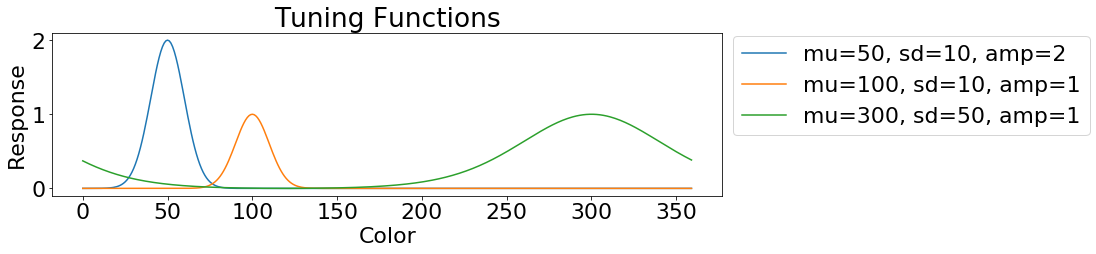

In [4]:
# Convenience functions
k2sd = lambda k : np.sqrt( -2 * np.log( sp.special.iv(1,k) / sp.special.iv(0,k) ) )

def sd2k(S):
    try:
        len(S)
    except:
        S = np.array([S])
    R = np.exp(-S**2/2)
    K = 1/(R**3 - 4 * R**2 + 3 * R)
    if np.any(R < 0.85):
        K[R < 0.85] = -0.4 + 1.39 * R[R < 0.85] + 0.43/(1 - R[R < 0.85])
    if np.any(R < 0.53):
        K[R < 0.53] = 2 * R[R < 0.53] + R[R < 0.53]**3 + (5 * R[R < 0.53]**5)/6
    if len(S) == 1:
        K = float(K)
    return K

def wrap360(a,b):
    try:
        len(a)
    except:
        a = np.array([a]); b= np.array([b])
    diff = np.full(len(a),np.nan)
    for k in np.arange(len(a)):
        diff[k] = b[k] - a[k]
        if diff[k] < -180:
            diff[k] = b[k] - a[k] + 360
        elif diff[k] > 180:
            diff[k] = b[k] - a[k] - 360
    return diff

def within360(y):
    x = copy.deepcopy(y)
    try:
        len(x)
    except:
        x = np.array([x])
    x[x>359] = x[x>359]-360
    x[x>359] = x[x>359]-360
    x[x<0] = x[x<0]+360
    return x

def within180(y):
    x = copy.deepcopy(y)
    try:
        len(x)
    except:
        x = np.array([x])
    x[x<0] = x[x<0]+360
    x[x>180] = x[x>180]-360
    return np.abs(x)

nchannels=6
def make_vonmises(xx,mu,sd,amp=np.ones(nchannels)/nchannels):
    try:
        try:
            len(amp)
        except:
            amp = np.array([amp])
        res = np.exp(sd2k(np.deg2rad(sd))*np.cos(np.deg2rad(xx-mu)))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd))))
        res[np.isnan(res)] = 0 # if requesting a stick function (very small sd), return a stick function
        if np.all(res==0):
            res[int(np.floor(mu))] = amp[0]
        norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
        return norm_res * amp[0]
    except: # if making multiple tuning functions at once
        res1 = np.full( (360,len(mu)) , np.nan)
        for i in range(len(mu)):
            res = np.exp(sd2k(np.deg2rad(sd[i]))*np.cos(np.deg2rad(xx-mu[i])))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd[i]))))
            res[np.isnan(res)] = 0 
            if np.all(res==0):
                res[int(np.floor(mu[i]))] = amp[i]
            norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
            res1[:,i] = norm_res * amp[i]
        return res1
    
print('demo of make_vonmises function:')
plt.plot(make_vonmises(np.linspace(0,359,360),50,10,2),label="mu=50, sd=10, amp=2")
plt.plot(make_vonmises(np.linspace(0,359,360),100,10,1),label="mu=100, sd=10, amp=1")
plt.plot(make_vonmises(np.linspace(0,359,360),300,50,1),label="mu=300, sd=50, amp=1")
plt.xlabel('Color')
plt.ylabel('Response')
plt.legend(bbox_to_anchor=(1, 1.05))
plt.title("Tuning Functions")
plt.show()

# function to automate neuron/voxel simulation:
def sim_vox(plotting=0):
    # Simulate neurons/voxels
    trial_features = np.random.permutation(np.arange(360))
    #trial_features = np.arange(360)
    trial_conds = np.tile(np.array([0,1]),ntrials//2)
    trial_by_vox = np.full([ntrials,nvoxels], np.nan)
    for vox in np.arange(nvoxels):
        vox_tuning = make_vonmises( 
            np.linspace(0,359,360),
            vox_by_neuron_mu[(vox*nneurons):((vox+1)*nneurons)],
            vox_by_neuron_sd[(vox*nneurons):((vox+1)*nneurons)],
            vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)])
        for trial in np.arange(ntrials):
            neuron_w_noise = vox_tuning[trial_features[trial],:] + (np.random.randn(nneurons)*neuron_noise)
            neuron_w_noise_and_gain = neuron_w_noise * (trial_conds[trial]*vox_gain_diff + 1)
            trial_by_vox[trial,vox] = np.sum(neuron_w_noise_and_gain)
    trial_by_vox = trial_by_vox.clip(min=0)
    if plotting:
        with plt.rc_context(rc={'font.size': 14, 'figure.figsize': (12,1)}):
            plt.hist(vox_mu,bins=30)
            plt.ylabel('Count')
            plt.title("Each voxel's maximal color preference")
            plt.show()
            plt.hist(vox_by_neuron_mu,bins=30)
            plt.ylabel('Count')
            plt.title("Each neuron's maximal color preference")
            plt.show()
            plt.hist(vox_by_neuron_amp,bins=30)
            plt.ylabel('Count')
            plt.title("Each neuron's amplitude if maximal stimulus")
            plt.show()
            plt.hist(vox_by_neuron_sd,bins=30)
            plt.ylabel('Count')
            plt.title("Each neuron's sd of tuning function")
            plt.show()
    return trial_by_vox, np.array(trial_features), trial_conds

# Simulate neurons and voxels

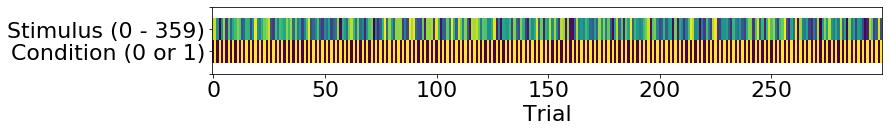

In [12]:
ntrials = 300
nvoxels = 100
nneurons = 100 # voxel activation = sum of nneurons
vox_mu_sd = .01
vox_sd_mu = 5
vox_sd_sd = .01
vox_gain_diff = 0 # difference in amplitude between trial conditions
neuron_noise = 20 # introduce noise for every neuron
feature_space = np.linspace(0,359,360) # full range of our continuous feature (here 360 degrees in color wheel)
trial_features = list(map(int,np.random.choice(feature_space, ntrials))) # feature presented on given trial
trial_conds = np.tile(np.array([0,1]),ntrials//2) # condition of given trial

basis_points = np.linspace(0,360-(360//nchannels),nchannels) # basis set centers
basis_points = list(map(int, basis_points))

# Plotting:
plt.imshow([trial_features,trial_conds*360],aspect=10)
plt.yticks([-1,0,1,2],['','Stimulus (0 - 359)','Condition (0 or 1)',''])
plt.xlabel('Trial')
plt.show()

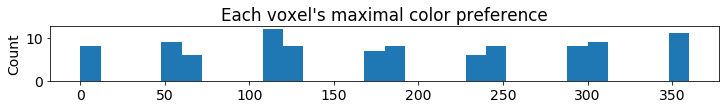

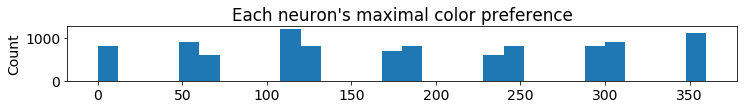

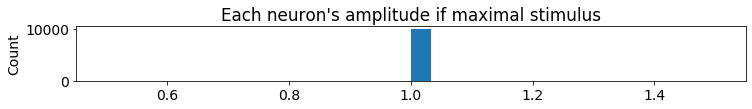

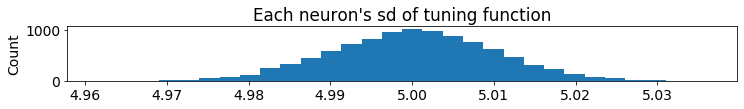

In [13]:
vox_nchannels = 6
vox_mu_basis = np.linspace(0,360-(360//vox_nchannels),vox_nchannels) # ground truth voxel receptive fields
vox_amp_basis = np.ones(vox_nchannels) # amplitude for given features

y_mu = pm.NormalMixture.dist(w=np.ones(vox_nchannels)/vox_nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(vox_nchannels)*vox_mu_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

vox_by_neuron_mu = np.repeat(vox_mu,nneurons)
vox_by_neuron_amp = np.full( (nvoxels*nneurons), np.nan)
for vox in np.arange(nvoxels):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(vox_mu[vox],len(basis_points)),basis_points) ) )
    vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)] = vox_amp_basis[closest_basis]
    
y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_by_neuron_sd = y_sd.random(size=(nvoxels*nneurons))

with plt.rc_context(rc={'font.size': 14, 'figure.figsize': (12,1)}):
    plt.hist(vox_mu,bins=30)
    plt.ylabel('Count')
    plt.title("Each voxel's maximal color preference")
    plt.show()
    plt.hist(vox_by_neuron_mu,bins=30)
    plt.ylabel('Count')
    plt.title("Each neuron's maximal color preference")
    plt.show()
    plt.hist(vox_by_neuron_amp,bins=30)
    plt.ylabel('Count')
    plt.title("Each neuron's amplitude if maximal stimulus")
    plt.show()
    plt.hist(vox_by_neuron_sd,bins=30)
    plt.ylabel('Count')
    plt.title("Each neuron's sd of tuning function")
    plt.show()

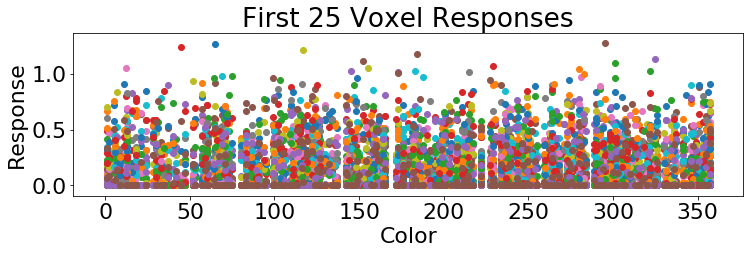

In [14]:
trial_by_vox = np.full([ntrials,nvoxels], np.nan)

for vox in np.arange(nvoxels):
    # for every voxel, we create tuning function across 100 neurons...
    vox_tuning = make_vonmises( 
        np.linspace(0,359,360),
        vox_by_neuron_mu[(vox*nneurons):((vox+1)*nneurons)],
        vox_by_neuron_sd[(vox*nneurons):((vox+1)*nneurons)],
        vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)])
    # we then add random neuron_noise, possible condition-specific amplitude changes, 
    # and then sum across how each neuron responds to each trial's feature for each voxel
    for trial in np.arange(ntrials):
        neuron_w_noise = vox_tuning[trial_features[trial],:] + (np.random.randn(nneurons)*neuron_noise)
        neuron_w_noise_and_gain = neuron_w_noise * (trial_conds[trial]*vox_gain_diff + 1)
        trial_by_vox[trial,vox] = np.sum(neuron_w_noise_and_gain)
trial_by_vox = trial_by_vox.clip(min=0)

for vox in np.arange(nvoxels):
    if vox <= 25:
        plt.scatter(trial_features,trial_by_vox[:,vox])
plt.xlabel('Color')
plt.ylabel('Response')
plt.yticks([0,np.max(trial_by_vox[:,vox])//2,np.max(trial_by_vox[:,vox])], [0.0,0.5,1.0])
plt.title('First 25 Voxel Responses')
plt.show()

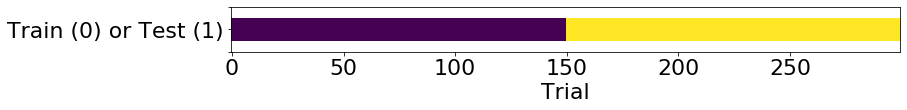

In [15]:
# Define training/testing trials
trn = trial_by_vox[:ntrials//2,:] # training: trial "Betas"
trnf = np.array(trial_features[:ntrials//2]) # training trial features
tst = trial_by_vox[ntrials//2:,:] # testing: trial "Betas"
tstf = np.array(trial_features[ntrials//2:]) # test trial features
trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

# Plotting:
plt.imshow([trn_or_tst*360],aspect=10)
plt.yticks([-1,0,1],['','Train (0) or Test (1)',''])
plt.xlabel('Trial')
plt.show()

# Inverted Encoding Model

## Create Forward Model & Design Matrix

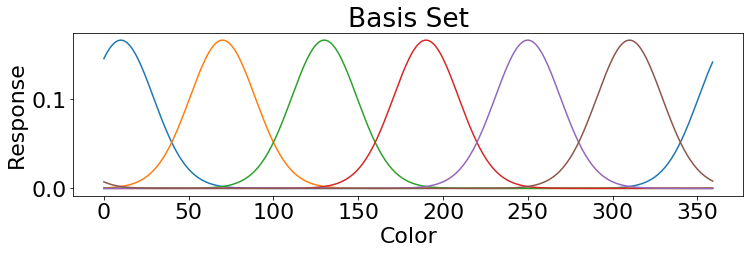

In [61]:
nchannels = 6
channel_sd = np.ones(nchannels)*20 # standard deviation of each basis
    
# create each basis channel
basis_set = make_vonmises(feature_space, basis_points, channel_sd)

# plot basis functions
for chan in np.arange(nchannels):
    plt.plot(basis_set[:,chan])

plt.xlabel('Color')
plt.ylabel('Response')
plt.title("Basis Set")
plt.show()

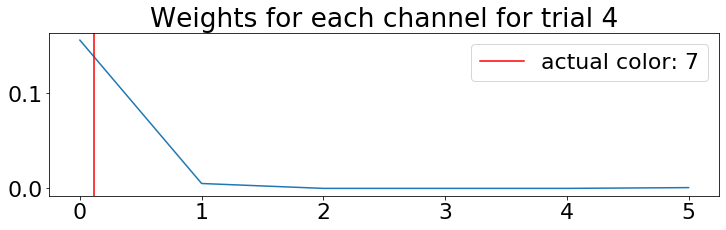

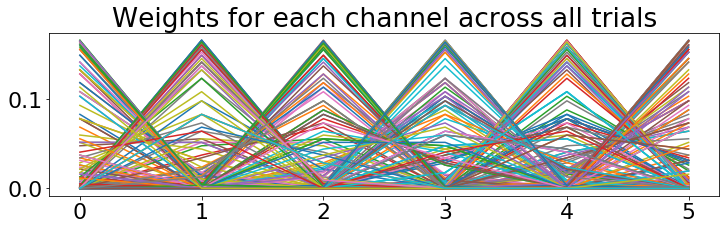

In [17]:
trial_weights = basis_set[trial_features,:]

trial = 3
plt.plot(trial_weights[trial,:])
plt.title("Weights for each channel for trial {}".format(trial+1))
plt.axvline(trial_features[trial]/360 * nchannels,color='red',label="actual color: {}".format(trial_features[trial]))
plt.legend()
plt.show()

for trial in np.arange(ntrials):
    plt.plot(trial_weights[trial,:])
plt.title('Weights for each channel across all trials')
plt.show()

## Test if channels are linearly dependent
Test to see if we have a full rank design matrix (tests if channels are linearly dependent). Linearly dependent channels are bad because it means that at least one of the channels can be defined as a linear combination of the others. This is bad because then we can't uniquely estimate the contribution of each channel to the signal observed in a given voxel. In other words, if trail_weights is not full rank then we have effectively lost the contribution of at least one of the nchannel dimensions.

In [18]:
print('Design matrix: rank = {}'.format( np.linalg.matrix_rank(trial_weights) ))
if np.linalg.matrix_rank(trial_weights) != nchannels:
    raise Exception('trial_weights not full rank')

Design matrix: rank = 6


## Compute weights of forward model

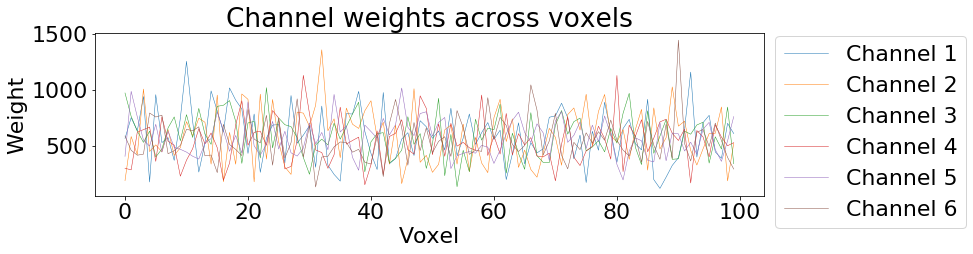

In [19]:
channelweights_per_vox = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
# solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

vox_idx = np.argmin(channelweights_per_vox[0,:])

for chan in range(nchannels):
    plt.plot(channelweights_per_vox[chan,:].T,linewidth=.5,label="Channel " + str(chan+1));
plt.title('Channel weights across voxels');
plt.xlabel("Voxel")
plt.ylabel("Weight")
plt.legend(bbox_to_anchor=(1, 1.05))

## Invert to compute channel responses

In [20]:
cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T
cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T

### Reconstruct training data (note: this is circular, it should be near-perfect!)

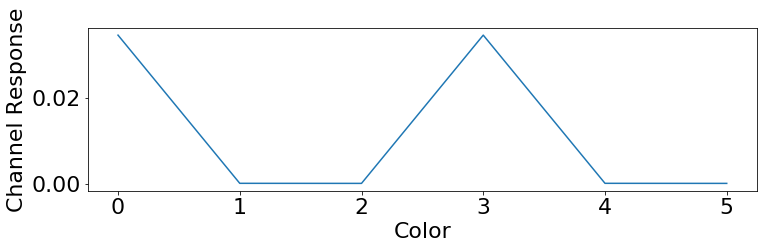

MAE: 96.73333333333333


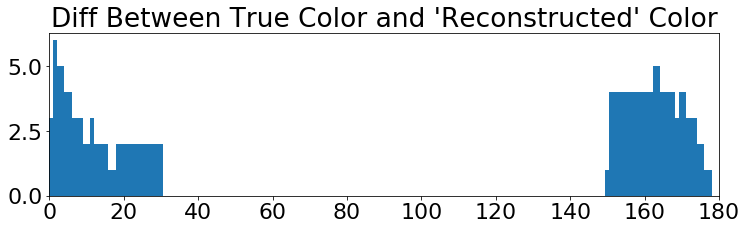

In [72]:
cr_center_trn = np.empty_like(cr_trn)
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    
plt.plot(np.mean(cr_center_trn,axis=0))
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

### Reconstruct test data

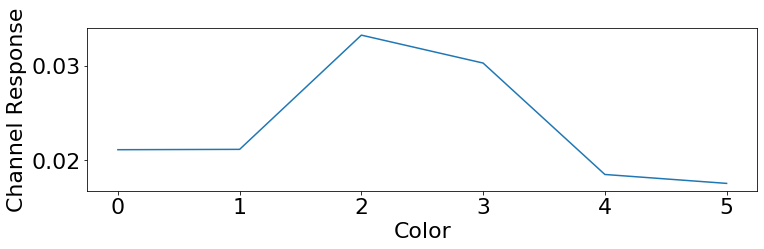

MAE: 79.67333333333333


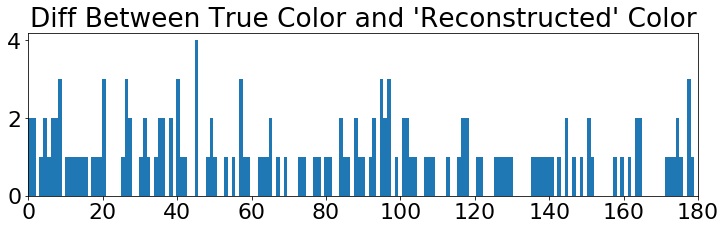

In [22]:
cr_center_tst = np.empty_like(cr_tst)
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    
plt.plot(np.mean(cr_center_tst,axis=0))
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

### Null Distribution / Significance Test

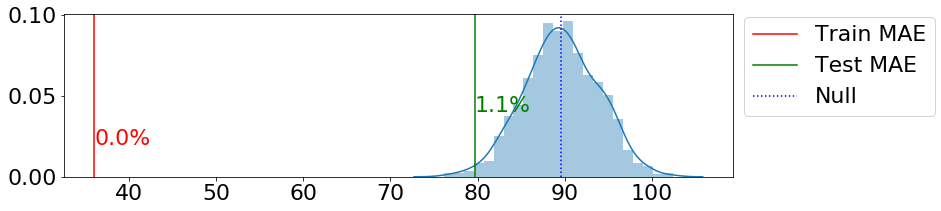

Model performance: 9.960146666666667


In [23]:
# Reconstruct the stimulus:
estimated_color = np.full(cr_tst.shape[0],np.nan)
null_mae = np.full(1000,np.nan)
for perm in np.arange(1000):
    shuffled_tst = np.random.permutation(tst)
    cr_shuffle_tst = np.linalg.lstsq(channelweights_per_vox.T , shuffled_tst.T, rcond=None)[0].T
    for trial in np.arange(cr_shuffle_tst.shape[0]):
        estimated_color[trial] = basis_points[np.argmax(cr_shuffle_tst[trial,:])]

    null_mae[perm] = np.mean(np.abs(wrap360(estimated_color, tstf)))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae) * 100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae) * 100

sns.distplot(null_mae)
plt.axvline(trn_mae,color='red',label="Train MAE")
plt.axvline(tst_mae,color='green',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='blue',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,.02,"{:.1f}%".format(trn_overlap),color='red')
plt.text(tst_mae,.04,"{:.1f}%".format(tst_overlap),color='green')
plt.show()

print("Model performance: {}".format(np.mean(null_mae - tst_mae)))

# Automate simulations
## Function to perform IEM on simulated data

In [5]:
%%cython

import cython
cimport cython

import numpy as np
cimport numpy as np

import warnings

def in360_scalar(x):
    while x>359:
        x=x-360
    while x<0:
        x=x+360
    return x

def correct_basis(x,nchannels):
    while len(x[x>359]) > 0:
        x[x>359] = x[x>359]-360
    while len(x[x<0]) > 0:
        x[x<0] = x[x<0]+360
    x = np.sort(x)
    if x[0] >= 360/nchannels/2:
        x = x-(360/nchannels)
    if x[0] < -360/nchannels/2:
        x = x+(360/nchannels)
    return x

def basis_features(basis_points,trial_features):
    b = np.argmin(np.abs(np.subtract.outer(np.concatenate([basis_points,[basis_points[0]+360]]), trial_features)),axis=0)
    b[b==np.max(b)]=0
    return b

In [6]:
def auto_recon(basis_points,channel_sd,trial_features,trial_by_vox):   
    # create each basis channel
    basis_points = correct_basis(basis_points,nchannels)
    basis_set = make_vonmises(feature_space, basis_points, channel_sd)
    trial_weights = basis_set[trial_features,:]

    X = np.linspace(0,ntrials-1,np.sum(ntrials))
    train_index = list(map(int,np.sort(X[:len(X)//2])))
    test_index = list(map(int,np.sort(X[len(X)//2:])))

    saved_weights = np.linalg.lstsq(trial_weights[train_index,:], trial_by_vox[train_index,:], rcond=None)[0] 
    # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

    # Invert to compute channel responses
    cr_tst = np.linalg.lstsq(saved_weights.T , trial_by_vox[test_index,:].T, rcond=None)[0].T
    # Plot perfect reconstruction for comparison
    shiftby = nchannels//2
    perfect_recon = basis_set[int(basis_points[0]),:][0:4]
    perfect_recon = perfect_recon / np.max(perfect_recon)
#     print(np.sum(perfect_recon),perfect_recon[shiftby])
#     plt.plot(perfect_recon);plt.show()
#     if np.argmax(perfect_recon) != shiftby:
#         print(basis_points)
#         print(perfect_recon)
#         plt.plot(perfect_recon)
#         raise ValueError('Shiftby Error')

    # Avg. reconstructions (testing)
    trial_actual = basis_features(basis_points,trial_features[test_index])
    trial_guess = np.argmax(cr_tst,axis=1)
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
    trial_diff = perfect_recon[trial_diff]
#     plt.plot(trial_diff);plt.show()
#     tst_mae = np.sum(trial_diff)
    tst_rmse = np.sqrt(np.mean(trial_diff**2))
    
#     # Null distribution testing
#     numperm=1000;null_mae=[]
#     for p in range(numperm):
#         tstf_shuffle = np.random.permutation(trial_features[test_index])
#         trial_actual = basis_features(basis_points,tstf_shuffle)
#         trial_guess = np.argmax(cr_tst,axis=1)
#         trial_diff = np.abs(trial_actual-trial_guess)
#         trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
#         trial_diff = perfect_recon[trial_diff]
#         null_mae.append(np.sum(trial_diff))
#     null_mae = np.mean(null_mae)

    return tst_rmse

def auto_recon_old(basis_points,channel_sd,trial_features,trial_by_vox,n_splits=2):   
    # create each basis channel
    basis_set = make_vonmises(feature_space, basis_points, channel_sd)
    trial_weights = basis_set[trial_features,:]
    
    cv_iter = -1
    for n in range(n_splits):
        X = np.linspace(0,ntrials-1,np.sum(ntrials))
        train_index = list(map(int,np.sort(X[:len(X)//2])))
        test_index = list(map(int,np.sort(X[len(X)//2:])))

        if cv_iter == -1:
            tstf=[];
            cr_tst = np.full((n_splits,len(test_index),nchannels),np.nan)
        cv_iter = cv_iter + 1

        tstf.append(trial_features[test_index])
        trn_or_tst = np.zeros(len(trial_features))
        trn_or_tst[test_index] = 1

        saved_weights = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trial_by_vox[train_index,:], rcond=None)[0] 
        # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

        # Invert to compute channel responses
        cr_tst[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[test_index,:].T, rcond=None)[0].T

    # collapse folds
    tstf = np.array(tstf).flatten()
    cr_tst = cr_tst.reshape(cr_tst.shape[1]*n_splits,nchannels)
    #full_saved_weights = np.linalg.lstsq(trial_weights, trial_by_vox, rcond=None)[0] 

    # Plot perfect reconstruction for comparison
    shiftby = nchannels//2
    perfect_recon = trial_weights[np.where(trial_features==shiftby*(360/nchannels))[0][0],:]

    # Avg. reconstructions (testing)
    cr_center_tst = np.empty_like(cr_tst)
    trial_actual = np.full(cr_tst.shape[0],999)
    trial_guess = np.full(cr_tst.shape[0],999)
    for trial in np.arange(cr_tst.shape[0]):
        trial_actual[trial] = np.argmin(np.abs(within180(basis_points - tstf[trial])))
        trial_guess[trial] = np.argmax(cr_tst[trial,:])
        cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
    trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
    tst_mae = np.mean(trial_diff)

    return tst_mae

def auto_recon_plotting(basis_points,channel_sd,trial_features,trial_by_vox,n_splits=2):   
    # create each basis channel
    basis_points = correct_basis(basis_points,nchannels)
    basis_set = make_vonmises(feature_space, basis_points, channel_sd)
    trial_weights = basis_set[trial_features,:]
    
    cv_iter = -1
    for n in range(n_splits):
        X = np.linspace(0,ntrials-1,np.sum(ntrials))
        train_index = list(map(int,np.sort(X[:len(X)//2])))
        test_index = list(map(int,np.sort(X[len(X)//2:])))

        if cv_iter == -1:
            trn=[];tst=[];trnf=[];tstf=[];
            cr_trn = np.full((n_splits,len(train_index),nchannels),np.nan)
            cr_tst = np.full((n_splits,len(test_index),nchannels),np.nan)
        cv_iter = cv_iter + 1

        trnf.append(trial_features[train_index])
        tstf.append(trial_features[test_index])
        trn_or_tst = np.zeros(len(trial_features))
        trn_or_tst[test_index] = 1

        saved_weights = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trial_by_vox[train_index,:], rcond=None)[0] 
        # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

        # Invert to compute channel responses
        cr_trn[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[train_index,:].T, rcond=None)[0].T
        cr_tst[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[test_index,:].T, rcond=None)[0].T

    # collapse folds
    trnf = np.array(trnf).flatten()
    tstf = np.array(tstf).flatten()
    cr_trn = cr_trn.reshape(cr_trn.shape[1]*n_splits,nchannels)
    cr_tst = cr_tst.reshape(cr_tst.shape[1]*n_splits,nchannels)
    #full_saved_weights = np.linalg.lstsq(trial_weights, trial_by_vox, rcond=None)[0] 

    # Plot perfect reconstruction for comparison
    shiftby = nchannels//2
            
    # Avg. reconstructions (training)
    cr_center_trn = np.empty_like(cr_trn)
    trial_actual = np.full(cr_trn.shape[0],999)
    trial_guess = np.full(cr_trn.shape[0],999)
    trial_actual = basis_features(basis_points,trnf)
    for trial in np.arange(cr_trn.shape[0]):
        trial_guess[trial] = np.argmax(cr_trn[trial,:])
        cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - trial_actual[trial]);
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
#     trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
    trn_mae = np.mean(trial_diff)

    # Avg. reconstructions (testing)
    cr_center_tst = np.empty_like(cr_tst)
    trial_actual = np.full(cr_tst.shape[0],999)
    trial_guess = np.full(cr_tst.shape[0],999)
    trial_actual = basis_features(basis_points,tstf)
    for trial in np.arange(cr_tst.shape[0]):
        trial_guess[trial] = np.argmax(cr_tst[trial,:])
        cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
#     trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
    tst_mae = np.mean(trial_diff)

    # Null distribution testing
    numperms = 1000
    cr_center_null = np.empty_like(cr_tst)
    trial_actual = np.full(cr_tst.shape[0],999)
    trial_guess = np.full(cr_tst.shape[0],999)
    null_mae = np.full(numperms,np.nan)
    for perm in np.arange(numperms):
        tstf_shuffle = np.random.permutation(tstf)
        trial_actual = basis_features(basis_points,tstf_shuffle)
        for trial in np.arange(cr_tst.shape[0]):
            trial_guess[trial] = np.argmax(cr_tst[trial,:])
            cr_center_null[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
        trial_diff = np.abs(trial_actual-trial_guess)
        trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
#         trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
        null_mae[perm] = np.mean(trial_diff)

    trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae)*100
    tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae)*100

    # Plotting
    print("train: avg MAE: {}".format(trn_mae))
    plt.plot(np.mean(cr_center_tst,axis=0),color='r')
    plt.title("Test")
    plt.xlabel("Color")
    plt.ylabel("Channel Response")
    plt.show()    
    plt.plot(np.mean(cr_center_trn,axis=0),color='b',label="Train")
    plt.plot(np.mean(cr_center_tst,axis=0),color='r',label="Test")
    plt.plot(np.mean(cr_center_null,axis=0),color='gray',label="Null")
    plt.title("All Reconstructions (overlaid)")
    plt.xlabel("Color")
    plt.ylabel("Channel Response")
    plt.legend()
    plt.show()
    print("test: avg MAE: {}".format(tst_mae))
    sns.distplot(null_mae,color='gray',bins=10)
    plt.axvline(trn_mae,color='blue',label="Train MAE")
    plt.axvline(tst_mae,color='red',label="Test MAE")
    plt.axvline(np.mean(null_mae),linestyle=':',color='gray',label="Null")
    plt.legend(bbox_to_anchor=(1, 1.05))
    plt.text(trn_mae,1,"{:.2f}%".format(trn_overlap),color='blue')
    plt.text(tst_mae,.25,"{:.2f}%".format(tst_overlap),color='red')
    plt.xlim([0,2])
    plt.show()
    print("null: avg MAE: {}".format(np.mean(null_mae)))
    print("% overlap w/ null distribution ({} permutations): {}%".format(numperms,tst_overlap))
    print("basically, this means p={:.3f}".format(tst_overlap/100))
    if tst_overlap < 5:
        print("meaning that test reconstructions are significantly different from null reconstructions.")
    else:
        print("meaning that test reconstructions are not significantly different from null reconstructions.")
    # Plot simulated voxel tunings:              
    ground_truth_set = make_vonmises(np.linspace(0,359,360),vox_mu_basis,np.ones(nchannels)*vox_sd_mu,vox_amp_basis)
    plt.plot(ground_truth_set/np.max(ground_truth_set))
    plt.ylabel('Response')
    plt.xlabel('Color')
    plt.yticks([])
    # Plot reconstructed basis sets:
    r_amps = np.full((nvoxels,2),np.nan)
    for vox in range(nvoxels):
        chan = np.argmin(np.abs(np.subtract.outer(np.concatenate([basis_points,[basis_points[0]+360]]), sp.stats.circmean(trial_features[np.argsort(trial_by_vox[:,vox])[-30:]],low=0,high=359))),axis=0)
        if chan >= nchannels:
            chan = 0
        #chan = np.argmin(np.abs(within180(basis_points - np.median(trial_features[np.argsort(trial_by_vox[:,vox])[-30:]]))))
        r_amps[vox,:] = chan,np.max(trial_by_vox[np.isin(trial_features,np.where(basis_set[:,chan]>np.max(basis_set[:,chan])/2)),vox])
    #r_amps[:,1] = r_amps[:,1]/np.max(r_amps[:,1])
    recon_amps = []
    for chan in range(nchannels):
        recon_amps.append(np.mean(r_amps[:,1][r_amps[:,0]==chan]))
    plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
    r_basis_set = make_vonmises(feature_space, basis_points, channel_sd, recon_amps)
    plt.plot(r_basis_set/np.max(r_basis_set),':',linewidth=5,alpha=.5)
    plt.show()
    print("null mae range: {},{}".format(np.min(null_mae),np.max(null_mae)))
    print("null_mae - tst_mae (larger positive number is better): {}".format(np.mean(null_mae - tst_mae)))
    print("tst_mae - trn_mae (smaller number is better): {}".format(np.mean(tst_mae - trn_mae)))
    return tst_mae, tst_overlap

def auto_recon_plotting_old(basis_points,channel_sd,trial_features,trial_by_vox,n_splits=2):   
    # create each basis channel
    basis_points = correct_basis(basis_points,nchannels)
    basis_set = make_vonmises(feature_space, basis_points, channel_sd)
    trial_weights = basis_set[trial_features,:]
    
    cv_iter = -1
    for n in range(n_splits):
        X = np.linspace(0,ntrials-1,np.sum(ntrials))
        train_index = list(map(int,np.sort(X[:len(X)//2])))
        test_index = list(map(int,np.sort(X[len(X)//2:])))

        if cv_iter == -1:
            trn=[];tst=[];trnf=[];tstf=[];
            cr_trn = np.full((n_splits,len(train_index),nchannels),np.nan)
            cr_tst = np.full((n_splits,len(test_index),nchannels),np.nan)
        cv_iter = cv_iter + 1

        trnf.append(trial_features[train_index])
        tstf.append(trial_features[test_index])
        trn_or_tst = np.zeros(len(trial_features))
        trn_or_tst[test_index] = 1

        saved_weights = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trial_by_vox[train_index,:], rcond=None)[0] 
        # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

        # Invert to compute channel responses
        cr_trn[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[train_index,:].T, rcond=None)[0].T
        cr_tst[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[test_index,:].T, rcond=None)[0].T

    # collapse folds
    trnf = np.array(trnf).flatten()
    tstf = np.array(tstf).flatten()
    cr_trn = cr_trn.reshape(cr_trn.shape[1]*n_splits,nchannels)
    cr_tst = cr_tst.reshape(cr_tst.shape[1]*n_splits,nchannels)
    #full_saved_weights = np.linalg.lstsq(trial_weights, trial_by_vox, rcond=None)[0] 

    # Plot perfect reconstruction for comparison
    shiftby = nchannels//2
    perfect_recon = basis_set[int(basis_points[shiftby]),:]
    perfect_recon = perfect_recon / np.max(perfect_recon)
    if np.argmax(perfect_recon) != shiftby:
        raise ValueError('Shiftby Error')
            
    # Avg. reconstructions (training)
    cr_center_trn = np.empty_like(cr_trn)
    trial_actual = np.full(cr_trn.shape[0],999)
    trial_guess = np.full(cr_trn.shape[0],999)
    trial_actual = basis_features(basis_points,trnf)
    for trial in np.arange(cr_trn.shape[0]):
        trial_guess[trial] = np.argmax(cr_trn[trial,:])
        cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - trial_actual[trial]);
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
    trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
    trn_mae = np.mean(trial_diff)

    # Avg. reconstructions (testing)
    cr_center_tst = np.empty_like(cr_tst)
    trial_actual = np.full(cr_tst.shape[0],999)
    trial_guess = np.full(cr_tst.shape[0],999)
    trial_actual = basis_features(basis_points,tstf)
    for trial in np.arange(cr_tst.shape[0]):
        trial_guess[trial] = np.argmax(cr_tst[trial,:])
        cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
    trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
    tst_mae = np.mean(trial_diff)

    # Null distribution testing
    numperms = 1000
    cr_center_null = np.empty_like(cr_tst)
    trial_actual = np.full(cr_tst.shape[0],999)
    trial_guess = np.full(cr_tst.shape[0],999)
    null_mae = np.full(numperms,np.nan)
    for perm in np.arange(numperms):
        tstf_shuffle = np.random.permutation(tstf)
        trial_actual = basis_features(basis_points,tstf_shuffle)
        for trial in np.arange(cr_tst.shape[0]):
            trial_guess[trial] = np.argmax(cr_tst[trial,:])
            cr_center_null[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
        trial_diff = np.abs(trial_actual-trial_guess)
        trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
        trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
        null_mae[perm] = np.mean(trial_diff)

    trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae)*100
    tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae)*100

    # Plotting
    print("Reconstructions aligned at {} \n".format(shiftby))
    plt.plot(perfect_recon,color='k')
    plt.title("Perfect Reconstruction (for comparison)")
    plt.xlabel("Color")
    plt.ylabel("Channel Response")
    plt.show()
    plt.plot(np.mean(cr_center_trn,axis=0),color='b')
    plt.title("Train")
    plt.xlabel("Color")
    plt.ylabel("Channel Response")
    plt.show()
    print("train: avg MAE: {}".format(trn_mae))
    plt.plot(np.mean(cr_center_tst,axis=0),color='r')
    plt.title("Test")
    plt.xlabel("Color")
    plt.ylabel("Channel Response")
    plt.show()    
    plt.plot(np.mean(cr_center_trn,axis=0),color='b',label="Train")
    plt.plot(np.mean(cr_center_tst,axis=0),color='r',label="Test")
    plt.plot(np.mean(cr_center_null,axis=0),color='gray',label="Null")
    plt.title("All Reconstructions (overlaid)")
    plt.xlabel("Color")
    plt.ylabel("Channel Response")
    plt.legend()
    plt.show()
    print("test: avg MAE: {}".format(tst_mae))
    sns.distplot(null_mae,color='gray',bins=10)
    plt.axvline(trn_mae,color='blue',label="Train MAE")
    plt.axvline(tst_mae,color='red',label="Test MAE")
    plt.axvline(np.mean(null_mae),linestyle=':',color='gray',label="Null")
    plt.legend(bbox_to_anchor=(1, 1.05))
    plt.text(trn_mae,1,"{:.2f}%".format(trn_overlap),color='blue')
    plt.text(tst_mae,.25,"{:.2f}%".format(tst_overlap),color='red')
    plt.xlim([0,1])
    plt.show()
    print("null: avg MAE: {}".format(np.mean(null_mae)))
    print("% overlap w/ null distribution ({} permutations): {}%".format(numperms,tst_overlap))
    print("basically, this means p={:.3f}".format(tst_overlap/100))
    if tst_overlap < 5:
        print("meaning that test reconstructions are significantly different from null reconstructions.")
    else:
        print("meaning that test reconstructions are not significantly different from null reconstructions.")
    # Plot simulated voxel tunings:              
    ground_truth_set = make_vonmises(np.linspace(0,359,360),vox_mu_basis,np.ones(nchannels)*vox_sd_mu,vox_amp_basis)
    plt.plot(ground_truth_set/np.max(ground_truth_set))
    plt.ylabel('Response')
    plt.xlabel('Color')
    plt.yticks([])
    # Plot reconstructed basis sets:
    r_amps = np.full((nvoxels,2),np.nan)
    for vox in range(nvoxels):
        chan = np.argmin(np.abs(np.subtract.outer(np.concatenate([basis_points,[basis_points[0]+360]]), sp.stats.circmean(trial_features[np.argsort(trial_by_vox[:,vox])[-30:]],low=0,high=359))),axis=0)
        if chan >= nchannels:
            chan = 0
        #chan = np.argmin(np.abs(within180(basis_points - np.median(trial_features[np.argsort(trial_by_vox[:,vox])[-30:]]))))
        r_amps[vox,:] = chan,np.max(trial_by_vox[np.isin(trial_features,np.where(basis_set[:,chan]>np.max(basis_set[:,chan])/2)),vox])
    #r_amps[:,1] = r_amps[:,1]/np.max(r_amps[:,1])
    recon_amps = []
    for chan in range(nchannels):
        recon_amps.append(np.mean(r_amps[:,1][r_amps[:,0]==chan]))
    plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
    r_basis_set = make_vonmises(feature_space, basis_points, channel_sd, recon_amps)
    plt.plot(r_basis_set/np.max(r_basis_set),':',linewidth=5,alpha=.5)
    plt.show()
    print("null mae range: {},{}".format(np.min(null_mae),np.max(null_mae)))
    print("null_mae - tst_mae (larger positive number is better): {}".format(np.mean(null_mae - tst_mae)))
    print("tst_mae - trn_mae (smaller number is better): {}".format(np.mean(tst_mae - trn_mae)))
    return tst_mae, tst_overlap
    
def plot_basis_avg(basis_points,channel_sd,trial_features,chan_pow=np.ones(nchannels)/nchannels): 
    # reset default matplotlib color picker
    plt.gca().set_prop_cycle(None)
    
    # create each basis channel
    basis_set = make_vonmises(feature_space, basis_points, channel_sd, chan_pow)
        
    # plot basis functions
    for chan in np.arange(nchannels):
        plt.plot(basis_set[:,chan])

    plt.xlabel('Color')
    plt.ylabel('Response')
    plt.yticks([])
    plt.title("Reconstructed Basis Set",color='green') 
    
def plot_basis_dotted(basis_points,channel_sd,trial_features,chan_pow=np.ones(nchannels)/nchannels): 
    # reset default matplotlib color picker
    plt.gca().set_prop_cycle(None)
    
    # create each basis channel
    basis_set = make_vonmises(feature_space, basis_points, channel_sd, chan_pow)
        
    # plot basis functions
    for chan in np.arange(nchannels):
        plt.plot(basis_set[:,chan],':')

## Simulation of data in one cell

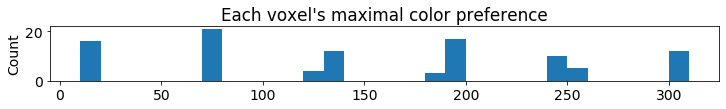

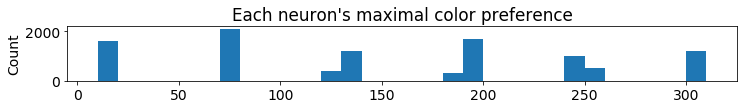

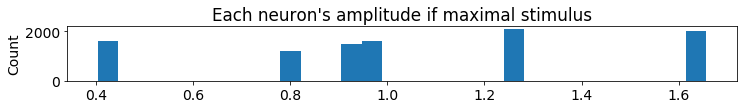

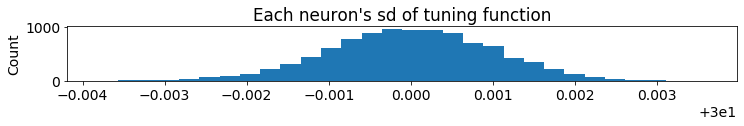

In [7]:
ntrials = 360
nvoxels = 100
nneurons = 100 # voxel activation = sum of nneurons
vox_mu_sd = .001
vox_sd_mu = 30
vox_sd_sd = .001
vox_gain_diff = 0 # difference in amplitude between trial conditions
neuron_noise = .001 # introduce noise for every neuron
feature_space = np.linspace(0,359,360) # full range of our continuous feature (here 360 degrees in color wheel)

nchannels = 6
vox_nchannels = 6
channel_sd = np.ones(nchannels)*vox_sd_mu
vox_mu_basis = np.linspace(0,360-(360//vox_nchannels),vox_nchannels)+10 # ground truth voxel receptive fields
basis_points = vox_mu_basis
vox_amp_basis = np.ones(vox_nchannels) # amplitude for given features

# randomize the amplitudes of the vox basis set
y_amp = pm.Dirichlet.dist(a=np.ones(nchannels)/nchannels)
vox_amp_basis = np.mean(y_amp.random(size=25),axis=0) * nchannels

y_mu = pm.NormalMixture.dist(w=np.ones(vox_nchannels)/vox_nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(vox_nchannels)*vox_mu_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

vox_by_neuron_mu = np.repeat(vox_mu,nneurons)
vox_by_neuron_amp = np.full( (nvoxels*nneurons), np.nan)

for vox in np.arange(nvoxels):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(vox_mu[vox],len(vox_mu_basis)),vox_mu_basis) ) )
    vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)] = vox_amp_basis[closest_basis]
    
y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_by_neuron_sd = y_sd.random(size=(nvoxels*nneurons))

trial_by_vox, trial_features, trial_conds = sim_vox(plotting=1)

# tst_mae, tst_overlap = auto_recon_plotting_old(basis_points,channel_sd,trial_features,trial_by_vox)

# print('\n--LARGE--\n')

# auto_recon_plotting_old(basis_points,channel_sd+25,trial_features,trial_by_vox)

# print('\n--SMALL--\n')

# auto_recon_plotting_old(basis_points,channel_sd-25,trial_features,trial_by_vox)


# MCMC Fitting: Find the optimal basis set

In [715]:
# define a theano Op for our likelihood function
class LogLikeWithGrad(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.likelihood, self.data, self.x, self.sigma)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.data, self.x, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        return [g[0]*self.logpgrad(theta)]

class LogLikeGrad(tt.Op):

    """
    This Op will be called with a vector of values and also return a vector of
    values - the gradients in each dimension.
    """
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        theta, = inputs

        # define version of likelihood function to pass to derivative function
        def lnlike(values):
            return self.likelihood(values, self.data, self.x, self.sigma)

        # calculate gradients
#         print(theta,lnlike)
        grads = sp.optimize.approx_fprime(theta, lnlike, .1)

        outputs[0][0] = grads

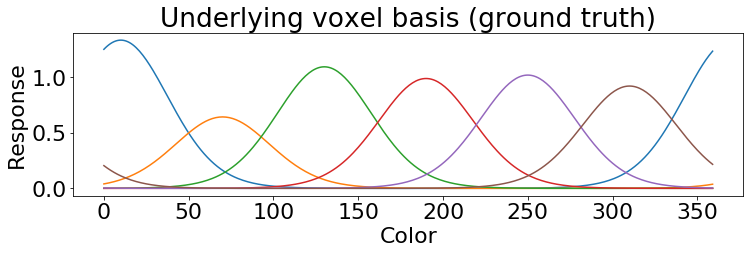

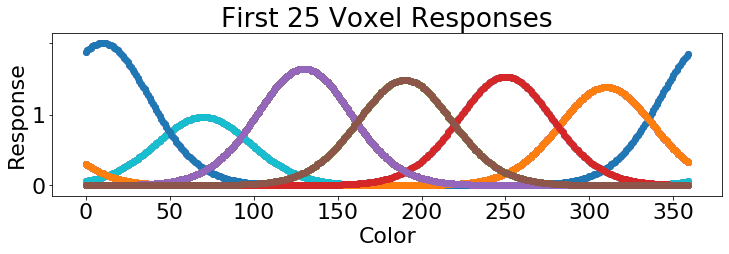

In [716]:
# Plot simulated voxel tunings:               
plt.plot(make_vonmises(np.linspace(0,359,360),vox_mu_basis,np.ones(nchannels)*vox_sd_mu,vox_amp_basis))
plt.title('Underlying voxel basis (ground truth)') 
plt.ylabel('Response')
plt.xlabel('Color')
plt.show()

# Plot actual voxel tunings:
for vox in np.arange(nvoxels):
    if vox <= 25:
        plt.scatter(trial_features,trial_by_vox[:,vox])
plt.xlabel('Color')
plt.ylabel('Response')
plt.yticks([0,np.max(trial_by_vox[:,vox])//2,np.max(trial_by_vox[:,vox])], [0,1])
plt.title('First 25 Voxel Responses')
plt.show()

## Find sh

In [722]:
# setup parameter priors
basis_points = np.linspace(0,360-(360//nchannels),nchannels)
true_sh = vox_mu_basis-basis_points

def pseudo_loglike(theta,basis_points,trial_features,trial_by_vox):
    sh = np.rad2deg(theta) / nchannels
    return -(1/(auto_recon(basis_points+sh,np.ones(nchannels)*vox_sd_mu,trial_features,trial_by_vox)**2))
    #gradient seems best with negative number, better performance is closer to zero, usually 10s digit (e.g., -13)

# create our Op
logl = LogLikeWithGrad(pseudo_loglike, basis_points, trial_features, trial_by_vox)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    sh_p = pm.Uniform('sh_p', lower=-np.pi, upper=np.pi)
    sh_k_p = pm.Gamma('k_p',2,.01)

    sh = pm.VonMises('sh', mu=sh_p, kappa=sh_k_p)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([sh])

    # use a DensityDist
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

#     trace = pm.sample(1000,tune=1000)
    modelfit = pm.fit(50000, method='advi')

# display(pm.summary(trace))
pm.summary(modelfit.sample(1000))

Average Loss = 4.8855: 100%|██████████| 50000/50000 [07:39<00:00, 108.89it/s]
Finished [100%]: Average Loss = 4.8772


,mean,sd,mc_error,hpd_2.5,hpd_97.5
sh_p,0.054121,0.106128,0.003157,-0.159555,0.249940
k_p,148.638619,128.526280,4.729900,10.673593,398.537814
sh,0.066745,0.103483,0.003269,-0.128778,0.267426


,mean,sd,mc_error,hpd_2.5,hpd_97.5
sh_p,0.419995,0.101473,0.003266,0.229047,0.616045
k_p,143.385894,119.646301,3.753032,12.420615,373.974174
sh,0.411444,0.110085,0.003329,0.168264,0.603952


ground truth basis MAE:  0.991756351396944
model-fitted basis MAE:  0.9665467845096487
true sh: [10. 10. 10. 10. 10. 10.]

model sh: 3.9290028206234706
 hpd: [1.60680724 5.76731934]



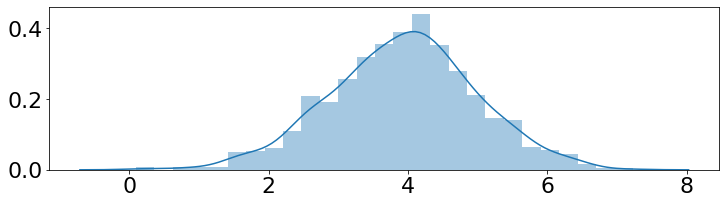

In [718]:
posterior = modelfit.sample(1000)
display(pm.summary(posterior,include_circ=True))
sns.distplot(np.rad2deg(posterior['sh']) / nchannels)

model_sh = np.rad2deg(np.mean(posterior['sh'])) / nchannels

print('ground truth basis MAE: ', auto_recon(basis_points+true_sh,np.ones(nchannels)*vox_sd_mu,trial_features,trial_by_vox))
print('model-fitted basis MAE: ', auto_recon(basis_points+model_sh,np.ones(nchannels)*vox_sd_mu,trial_features,trial_by_vox))
print('true sh: {}\n'.format(true_sh))
print('model sh: {}\n hpd: {}\n'.format(model_sh,np.rad2deg(pm.stats.hpd(posterior['sh'])/nchannels)))

## Find sd

In [608]:
# setup parameter priors
basis_points = vox_mu_basis
true_sd = vox_sd_mu

def pseudo_loglike(theta,basis_points,trial_features,trial_by_vox):
    sd = theta
    return -(1/(auto_recon(basis_points,np.ones(nchannels)*sd,trial_features,trial_by_vox)**10))
    #gradient seems best with negative number, better performance is closer to zero, usually 10s digit (e.g., -13)

# create our Op
logl = LogLikeWithGrad(pseudo_loglike, basis_points, trial_features, trial_by_vox)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    sd_p = pm.TruncatedNormal('sd_p', mu=30., sigma=20., lower=5., upper=120.)
    sd_sigma_p = pm.Gamma('sd_sigma_p',2,.1)

    sd = pm.TruncatedNormal('sd',mu=sd_p,sigma=sd_sigma_p,lower=5.,upper=120.)

    theta = tt.as_tensor_variable([sd])

    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    trace = pm.sample(1000,tune=1000)
#     modelfit = pm.fit(100000, method='advi')

display(pm.summary(trace))
# pm.summary(modelfit.sample(1000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, sd_sigma_p, sd_p]
Sampling 2 chains: 100%|██████████| 4000/4000 [15:30<00:00,  4.30draws/s] 
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sd_p,40.984941,18.337636,0.692642,5.116863,71.785995,593.568154,1.000051
sd_sigma_p,25.034200,15.460821,0.559220,3.198747,54.727103,736.906148,1.001469
sd,60.440963,25.382775,0.893797,11.847519,105.157113,730.763701,1.001912


,mean,sd,mc_error,hpd_2.5,hpd_97.5
sd_p,45.026670,16.593117,0.530921,16.951464,77.811578
sd_sigma_p,29.940348,15.255689,0.484337,7.072873,58.916315
sd,66.759457,22.380672,0.815649,25.817494,108.512692


ground truth basis MAE:  175.60909014461564
model-fitted basis MAE:  178.03721283854946
true sh: 30

model sd: 66.7594574126754
 hpd: [ 25.81749447 108.512692  ]



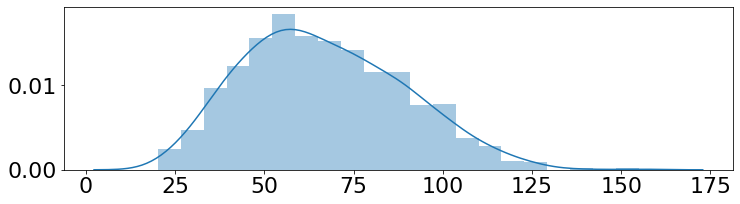

In [580]:
posterior = modelfit.sample(1000)
display(pm.summary(posterior))
sns.distplot(posterior['sd'])

model_sd = np.mean(posterior['sd'])

print('ground truth basis MAE: ', auto_recon(basis_points,np.ones(nchannels)*vox_sd_mu,trial_features,trial_by_vox))
print('model-fitted basis MAE: ', auto_recon(basis_points,np.ones(nchannels)*model_sd,trial_features,trial_by_vox))
print('true sh: {}\n'.format(true_sd))
print('model sd: {}\n hpd: {}\n'.format(model_sd,pm.stats.hpd(posterior['sd'])))

## Find optimal shifting, bandwidths, and amplitudes

In [180]:
# setup parameter priors
basis_points = np.linspace(0,360-(360//nchannels),nchannels)
true_sh = vox_mu_basis - basis_points
true_sd = np.ones(nchannels)*vox_sd_mu

def pseudo_loglike(theta,basis_points,channel_sd,trial_features,trial_by_vox):
    sh = theta[0:nchannels]
    sd = theta[nchannels:]
    err, chan_weights = auto_recon(basis_points+sh,sd,trial_features,trial_by_vox)
    return -(err**4)

# create our Op
logl = LogLike0(pseudo_loglike,basis_points,channel_sd,trial_features,trial_by_vox)

# fit the model
with pm.Model():
    # Priors
    sh_p = pm.Uniform('sh_p', lower=0., upper=(360/nchannels)/2)
    sd_p = pm.TruncatedNormal('sd_p', mu=30., sigma=20., lower=5.)
    
    sh_sigma_p = pm.Exponential('sh_sigma_p',1)
    sd_sigma_p = pm.Exponential('sd_sigma_p',1)
    
    for chan in np.arange(nchannels):
        locals()['sh{}'.format(chan)] = pm.Normal('sh{}'.format(chan),
                                                   mu=sh_p,sigma=sh_sigma_p)
        locals()['sd{}'.format(chan)] = pm.TruncatedNormal('sd{}'.format(chan),
                                           mu=sd_p,sigma=sd_sigma_p)
    
    # convert to a tensor vector
    theta = tt.as_tensor_variable([sh0,sh1,sh2,sh3,sh4,sh5,
                                   sd0,sd1,sd2,sd3,sd4,sd5])
    
    # use a custom blackbox function (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    trace = pm.sample(200, tune=300, chains=2)

KeyboardInterrupt: 

# Compare With MVPA

Let's say we want to decode (e.g., classify) whether there is signal in our ROI that is different for conditions 1 and 2. Given all the voxels we have from half our dataset, can we decode above chance whether a trial was condition 1 or 2?

In [118]:
trn = trial_by_vox[:ntrials//2,:]
trn_cond = trial_conds[:ntrials//2]
trnf = trial_features[:ntrials//2]

tst = trial_by_vox[ntrials//2:,:]
tst_cond = trial_conds[ntrials//2:]
tstf = trial_features[ntrials//2:]

normalizer = StandardScaler()
trn = normalizer.fit_transform(trn)
tst = normalizer.fit_transform(tst)

In [119]:
model = LinearSVC(C=1)

model.fit(trn, trn_cond)

score = model.score(tst, tst_cond)
print('Accuracy = {}'.format(score))
print('Chance = 0.50')

Accuracy = 0.5133333333333333
Chance = 0.50


What if we want to decode the actual color?

MAE: 63.38666666666666


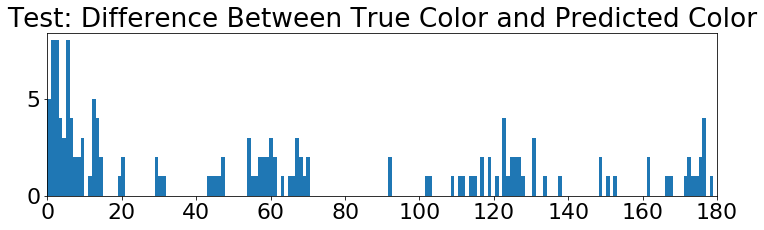

In [122]:
model.fit(trn, trnf)

predictions = model.predict(tst)

plt.hist(np.abs(wrap360(predictions, tstf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Test: Difference Between True Color and Predicted Color")

tst_mae = np.mean(np.abs(wrap360(predictions, tstf)))
print("MAE: {}".format(tst_mae))

# debugging .... testing gradients

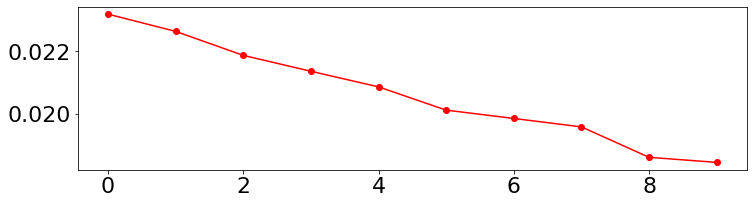

In [255]:
from sklearn.decomposition import PCA
n_components = 10
pca = PCA(copy=True, iterated_power='auto', n_components=n_components, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False).fit(trial_by_vox.T)
plt.plot(pca.explained_variance_ratio_, 'ro-') 
vox_weights = pca.transform(trial_by_vox.T)

In [131]:
# define a theano Op for our likelihood function
class LogLikeWithGrad(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.likelihood, self.data, self.x, self.sigma)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.data, self.x, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        return [g[0]*self.logpgrad(theta)]

class LogLikeGrad(tt.Op):

    """
    This Op will be called with a vector of values and also return a vector of
    values - the gradients in each dimension.
    """
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        theta, = inputs

        # define version of likelihood function to pass to derivative function
        def lnlike(values):
            return self.likelihood(values, self.data, self.x, self.sigma)

        # calculate gradients
#         print(theta,lnlike)
        grads = sp.optimize.approx_fprime(theta, lnlike, .1)

        outputs[0][0] = grads

In [123]:
def my_model(theta, x):
    m = theta
    return m*x + ctrue

def my_loglike(theta, data, x, sigma):
    model = my_model(theta, x)
    return -(0.5/sigma**2)*np.sum((data - model)**2)

In [124]:
# set up our data
N = 10  # number of data points
sigma = 1.  # standard deviation of noise
x = np.linspace(0., 9., N)

mtrue = 0.4  # true gradient
ctrue = 3.   # true y-intercept

truemodel = my_model([mtrue], x)

# make data
np.random.seed(716742)  # set random seed, so the data is reproducible each time
data = sigma*np.random.randn(N) + truemodel

In [125]:
# #test the gradient Op by direct call
# theano.config.compute_test_value = "ignore"
# theano.config.exception_verbosity = "high"

# var = tt.dvector()
# test_grad_op = LogLikeGrad(my_loglike, data, x, sigma)
# test_grad_op_func = theano.function([var], test_grad_op(var))

# print('Gradient returned by "LogLike": {}'.format(test_grad_op_func([mtrue,ctrue])))
# print('Gradient returned by "LogLike": {}'.format(test_grad_op_func([mtrue-.1,ctrue])))
# print('Gradient returned by "LogLike": {}'.format(test_grad_op_func([mtrue+.1,ctrue])))
# print('Gradient returned by "LogLike": {}'.format(test_grad_op_func([mtrue-1,ctrue])))
# print('Gradient returned by "LogLike": {}'.format(test_grad_op_func([mtrue+1,ctrue])))

# var = tt.dvector()
# test_grad_op = LogLikeWithGrad(my_loglike, data, x, sigma)
# test_grad_op_func = theano.function([var], test_grad_op(var))

# print('Gradient returned by "LogLikeWithGrad": {}'.format(test_grad_op_func([mtrue,ctrue])))

# print('Gradient returned by "LogLikeWithGrad": {}'.format(test_grad_op_func([mtrue-.1,ctrue])))

# print('Gradient returned by "LogLikeWithGrad": {}'.format(test_grad_op_func([mtrue+1,ctrue])))

In [15]:
def my_loglike(theta, data, x, sigma):
    model = my_model(theta, x)
    return -(0.5/sigma**2)*np.sum((data - model)**2)

# create our Op
logl = LogLikeWithGrad(my_loglike, data, x, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
#     c = pm.Uniform('c', lower=-10., upper=10.)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m])

    # use a DensityDist
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    trace = pm.sample(500)
#     modelfit = pm.fit(2500,method='advi')

# plot the traces
display(pm.summary(trace))
# pm.summary(modelfit.sample(1000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:04<00:00, 440.06draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m,0.390182,0.060821,0.004777,0.282901,0.5233,67.747672,1.025471


In [115]:
data = basis_points
x = trial_features
sigma = trial_by_vox

def my_loglike(theta,basis_points,trial_features,trial_by_vox):
    #sh = np.rad2deg(theta) / nchannels
    return -(1/(1-auto_recon(basis_points+(np.rad2deg(theta)/nchannels),np.ones(nchannels)*vox_sd_mu,trial_features,trial_by_vox)))**2

# create our Op
logl = LogLikeWithGrad(my_loglike, data, x, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    sh_p = pm.Uniform('sh_p', lower=-np.pi, upper=np.pi)
    k_p = pm.Gamma('k_p',2,.01)
    
#     sh = pm.VonMises('sh', mu=sh_p, kappa=k_p)
#     m = pm.TruncatedNormal('m', mu=sh_p, sigma=k_p, lower=0., upper=60.)

    m = pm.VonMises('m', mu=sh_p, kappa=k_p)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m])

    # use a DensityDist
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

#     trace = pm.sample(1000)
    modelfit = pm.fit(50000, method='advi')

# plot the traces
# display(pm.summary(trace))
pm.summary(modelfit.sample(1000))

Average Loss = 4.927: 100%|██████████| 100000/100000 [20:57<00:00, 79.53it/s] 
Finished [100%]: Average Loss = 4.928


,mean,sd,mc_error,hpd_2.5,hpd_97.5
sh_p,0.986990,0.094176,0.002918,0.808132,1.175301
k_p,161.400236,136.006221,3.963987,15.590444,431.352503
m,0.983283,0.088570,0.003140,0.804718,1.147204


In [129]:
data = basis_points
x = trial_features
sigma = trial_by_vox

def my_loglike(theta,basis_points,trial_features,trial_by_vox):
    #sh = np.rad2deg(theta) / nchannels
    return -(1/(1-auto_recon(basis_points+(np.rad2deg(theta)/nchannels),np.ones(nchannels)*vox_sd_mu,trial_features,trial_by_vox)))**2

# create our Op
logl = LogLikeWithGrad(my_loglike, data, x, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    sh_p = pm.Uniform('sh_p', lower=-np.pi, upper=np.pi)
    k_p = pm.Gamma('k_p',2,.01)
    
#     sh = pm.VonMises('sh', mu=sh_p, kappa=k_p)
#     m = pm.TruncatedNormal('m', mu=sh_p, sigma=k_p, lower=0., upper=60.)

    m = pm.VonMises('m', mu=sh_p, kappa=k_p)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m])

    # use a DensityDist
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

#     trace = pm.sample(1000)
    modelfit = pm.fit(50000, method='advi')

# plot the traces
# display(pm.summary(trace))
pm.summary(modelfit.sample(1000))

Average Loss = 5.5372: 100%|██████████| 50000/50000 [16:29<00:00, 50.53it/s]
Finished [100%]: Average Loss = 5.533


,mean,sd,mc_error,hpd_2.5,hpd_97.5
sh_p,0.764834,0.104493,0.002712,0.566616,0.962431
k_p,141.634016,127.115888,3.862946,12.352513,359.348530
m,0.754060,0.099617,0.003318,0.567979,0.953102


In [766]:
def pseudo_loglike(theta,basis_points,trial_features,trial_by_vox):
    #sh = np.rad2deg(theta) / nchannels
    sh = theta
    return auto_recon(basis_points+sh,np.ones(nchannels)*vox_sd_mu,trial_features,trial_by_vox)

#test the gradient Op by direct call
theano.config.compute_test_value = "ignore"
theano.config.exception_verbosity = "high"

var = tt.dvector()
test_grad_op = LogLikeGrad(pseudo_loglike,basis_points,trial_features,trial_by_vox)
test_grad_op_func = theano.function([var], test_grad_op(var))

print('Gradient returned by "LogLikeGrad": {}'.format(test_grad_op_func([10])))
print('Gradient returned by "LogLikeGrad": {}'.format(test_grad_op_func([7])))
print('Gradient returned by "LogLikeGrad": {}'.format(test_grad_op_func([60])))

var = tt.dvector()
test_grad_op = LogLikeWithGrad(pseudo_loglike,basis_points,trial_features,trial_by_vox)
test_grad_op_func = theano.function([var], test_grad_op(var))

print('Gradient returned by "LogLikeWithGrad": {}'.format(test_grad_op_func([10])))
print('Gradient returned by "LogLikeWithGrad": {}'.format(test_grad_op_func([0])))
print('Gradient returned by "LogLikeWithGrad": {}'.format(test_grad_op_func([60])))

Gradient returned by "LogLikeGrad": [8.93138349e-06]
Gradient returned by "LogLikeGrad": [2.3631379e-05]
Gradient returned by "LogLikeGrad": [4.97326255e-05]
Gradient returned by "LogLikeWithGrad": 0.07449647696784305
Gradient returned by "LogLikeWithGrad": 0.414778829617944
Gradient returned by "LogLikeWithGrad": 0.414778829617944
